In [1]:
import sys
# sys.path.append('/home/ajhnam/plinko_nn/src')
# sys.path.append('/home/plinkoproj/plinko_nn/src')
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.model.predictor_gru import GRUPredictor_mu
from plinko.model.predictor_gru import GRUPredictor_determ
from plinko.misc import plot as plinko_plot

# import matplotlib.pyplot as plt
# from plotnine import *
# %matplotlib inline

Loading chipmunk for Linux (64bit) [/opt/anaconda3/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [2]:
# device = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [3]:
# repo_path = '/home/plinkoproj/plinko_nn'
repo_path = '../'
df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

# df_ball = pd.read_feather(repo_path + '/data/training/sim_ball.feather')
# df_env = pd.read_feather(repo_path + '/data/training/sim_environment.feather')
# df_col = pd.read_feather(repo_path + '/data/training/sim_collisions.feather')

In [54]:
sim_data = data_utils.get_sim_data(df_ball, df_col)
selected_runs = sim_data[(sim_data.num_collisions == 2)
                         & (sim_data.duration < 80)
                         & (sim_data.run <= 20)]
simulations, environments = data_utils.create_task_df(selected_runs, df_ball, df_env)
states, envs = data_utils.to_tensors(simulations, environments, device)

In [41]:
# print(selected_runs)
# print(df_ball)
# simulations.t.max()
# print(df_col[df_col['simulation'] == 'sim_1'])

# del df_ball, df_env, df_col

# print(states.shape)
# print(envs.shape)
# print(states[0, :, 2])
print(states)

tensor([[[ 2.5451,  8.9033, 14.6438, 13.2594],
         [ 2.5391,  8.8720, 14.6438, 12.9023],
         [ 2.5332,  8.8348, 14.6438, 12.5451],
         ...,
         [ 5.0362,  1.7555, 15.0000, 15.0000],
         [ 5.0362,  1.7555, 15.0000, 15.0000],
         [ 5.0362,  1.7555, 15.0000, 15.0000]],

        [[ 2.5510,  8.9025, 15.0016, 13.2143],
         [ 2.5511,  8.8705, 15.0016, 12.8571],
         [ 2.5511,  8.8326, 15.0016, 12.5000],
         ...,
         [ 5.8597,  1.7798, 15.0000, 15.0000],
         [ 5.8597,  1.7798, 15.0000, 15.0000],
         [ 5.8597,  1.7798, 15.0000, 15.0000]],

        [[ 2.5523,  8.9026, 15.0766, 13.2163],
         [ 2.5536,  8.8706, 15.0766, 12.8592],
         [ 2.5548,  8.8327, 15.0766, 12.5021],
         ...,
         [ 5.1841,  1.7701, 15.0000, 15.0000],
         [ 5.1841,  1.7701, 15.0000, 15.0000],
         [ 5.1841,  1.7701, 15.0000, 15.0000]],

        ...,

        [[ 2.5483,  8.9027, 14.8371, 13.2236],
         [ 2.5456,  8.8708, 14.8371, 12.8665]

In [6]:
def get_logp_loss(gm, targets, weight = None):
    logp_loss_all = -gm.log_p(targets)
    
    if weight is not None:
        logp_loss_all_weight = logp_loss_all * weight
#         print(logp_loss_all_weight[0])
        return logp_loss_all_weight.mean()
    else:
        return logp_loss_all.mean()

def get_mu_mse_loss(gm, targets):
    return F.mse_loss(gm.mu[:,:,0], targets)


In [7]:
def get_collision_weight(collisions, ratio):

    collision_weights = torch.zeros(collisions.shape[0],collisions.shape[1], device = device)
    # print(collision_weights)
    
    for i in range(collisions.shape[0]):
        for j in range(collisions.shape[1] - 1, -1, -1):
            if collisions[i,j - 1] == 1:
    #             print(i, j)
                collisions[i,j] = 0
            else:
                break

    for i in range(collisions.shape[0]):
        for j in range(collisions.shape[1]):
            if collisions[i,j] == 0:
                if j < 5:
                    collision_weights[i,j] = ratio - j * (ratio/5)
                else:
                    if collision_weights[i,j] == 0:
                        collision_weights[i,j] = 1
            elif collisions[i,j] == 1:
                for k in range(5):
                    if (j + k) < collisions.shape[1]:
                        collision_weights[i,j + k] = ratio - k * (ratio/5)
#     print(collision_weights)
    
    return collision_weights



def get_collision_weight_fast(collisions, ratio):
    collisions[:, 0] = 1
    collision_weights = collisions * (ratio - 1) + 1
    
    return collision_weights

In [56]:
# model = GRUPredictor(env_size=11, state_size=2, num_gaussians=2).to(device)
model = GRUPredictor_mu(env_size=11, state_size=2, num_gaussians=1, trainable_h0 = True).to(device)
# optimizer = optim.SGD(model.parameters(), lr=.001)
optimizer = optim.Adam(model.parameters(), lr = 10e-4, weight_decay=.001)
dataset = SimulationDataset(envs, states)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [27]:
# train GRU_mu
max_t = simulations.t.max()
epochs = 1000
losses = []
mu_overtime = []
sigma_overtime = []
target_overtime = []
# for epoch in tqdm(range(epochs+1)):
for epoch in tqdm(range(101)):
    epoch_loss = 0
    epoch_mse_loss = 0
    epoch_logp_loss = 0
    for batch_i, batch in enumerate(dataloader):
        optimizer.zero_grad()
            
#         print('Batch ', batch_i)
        gm = model(batch['envs'], batch['states'][:, :, :2], 0)
        collisions = batch['states'][:, :, 2]
        collision_weights = get_collision_weight_fast(collisions, ratio = 50)
        targets = batch['targets']
        
#         logp_loss = get_logp_loss(gm, targets)        
#         print('logp_loss is ', logp_loss)
        logp_loss = get_logp_loss(gm, targets, collision_weights)
#         print('logp_loss_weight is ', logp_loss)
        mse_loss = 10*get_mu_mse_loss(gm, targets)
#         loss = logp_loss + mse_loss
        loss = logp_loss + mse_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss
        epoch_logp_loss += logp_loss
        epoch_mse_loss += mse_loss
        losses.append((epoch, batch_i, float(loss)))
        
        
        if batch_i == 0:
            gm_mu = gm.mu[:,:,0]
            target_mu = targets
            gm_sigma = gm.sigma[:,:,0]
        
    mu_overtime.append(gm_mu)
    sigma_overtime.append(gm_sigma)
    target_overtime.append(target_mu)    
    
    if epoch%1 == 0:
        print('Epoch {} | logp: {} | mse: {} | total: {}'.format(epoch,
                                                                 round(float(epoch_logp_loss), 4),
                                                                 round(float(epoch_mse_loss), 4),
                                                                 round(float(epoch_loss), 4)))
    
#     if (loss - prev_loss) < .1 and (loss - prev_loss) > -.1:
#         break
    
torch.save(model.state_dict(), 'gru.model')
torch.save(mu_overtime, 'mu_overtime.pt')
torch.save(sigma_overtime, 'sigma_overtime.pt')
torch.save(target_overtime, 'target_overtime.pt')
torch.save(losses, 'losses.pt')

AttributeError: 'tuple' object has no attribute 'log_p'

In [9]:
mu_overtime = torch.load('mu_overtime.pt')
sigma_overtime = torch.load('sigma_overtime.pt')
target_overtime = torch.load('target_overtime.pt')
losses = torch.load('losses.pt')

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('gru.model'))
model.eval()

GRUPredictor_mu(
  (env_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=32, bias=True)
    )
  )
  (state_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=16, bias=True)
    )
  )
  (gru): GRU(48, 128, num_layers=2)
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=6, bias=True)
    )
  )
)

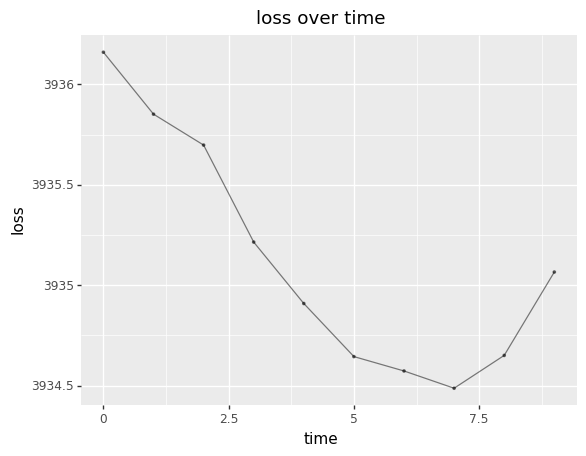

<ggplot: (8759600494201)>


In [52]:
# print(losses)
plinko_plot.plot_losses(losses)
# plinko_plot.plot_mu_over_time(p_overtime)
# plinko_plot.plot_variance_over_time(sigma_overtime)

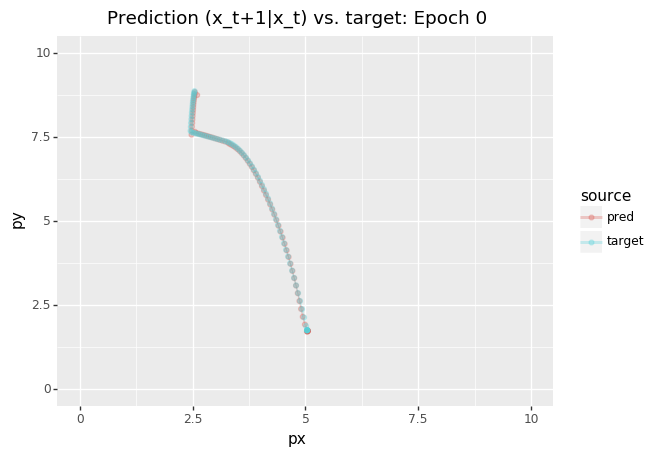

<ggplot: (8733014998445)>


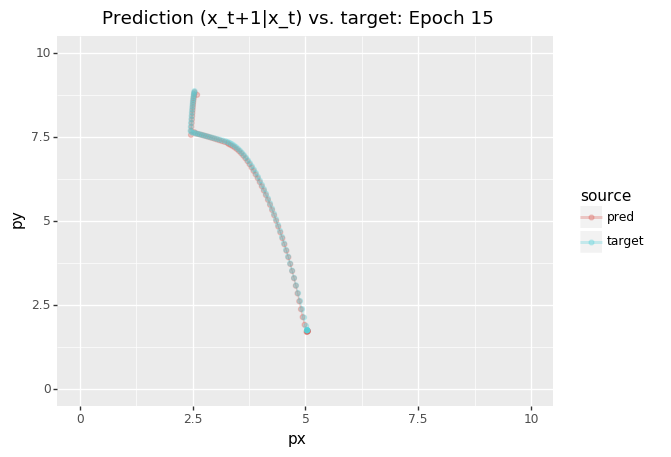

<ggplot: (8733015052769)>


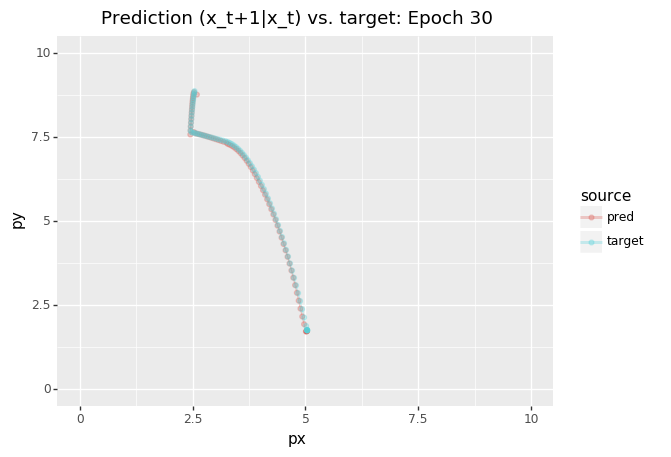

<ggplot: (8733011695153)>


In [67]:
# print(target_overtime[0][:, :, 2:])

for t in range(len(p_overtime)):
    if t %15 == 0:
        plinko_plot.plot_pred_target(p_overtime[t], target_overtime[t][:, :, :2], sim_range = range(1), alpha = .3,
                                    title = "Prediction (x_t+1|x_t) vs. target: Epoch {}".format(t))

In [35]:
# print(target_overtime[1])

for t in range(len(mu_overtime)):
    if t %10 == 0:
        plinko_plot.plot_pred_gaussian(mu_overtime[t], target_overtime[t], sigma_overtime[t], sim_index = 0, 
                                   title = "95% ellipse of predicted gaussian: Epoch {}".format(t), 
                                       color = 'red', alpha = .2)

NameError: name 'mu_overtime' is not defined

In [13]:
def simulate_model(model, dataset, sim_t=1):
    """
    :sim_t = how many time points to feed in for the simulation
    """
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    i = 0
    for batch in dataloader:
        i += 1
        with torch.no_grad():
            sates = model(batch['envs'], batch['states'][:, 0:sim_t], dataset[0]['states'].shape[0] - sim_t)
            targets = batch['targets'][:, 1:101]
            envs = batch['envs']
            #             df_env, df_ball = data_utils.create_simdata_from_samples(samples, batch['envs'],sim_df, env_df)

            return states, targets, envs

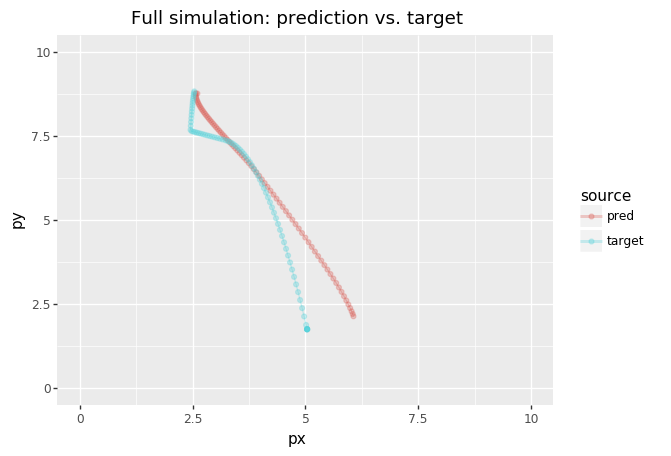

<ggplot: (8733011685465)>


In [68]:
# print(sim_samples.shape)
# print(sim_targets.shape)
# print(gm.mu.shape)

# print(dataset[0]['states'].shape[0])
# simulate from trained model
sim_states, sim_targets, sim_envs = simulate_model(model, dataset, sim_t = 1)

plinko_plot.plot_pred_target(sim_states, sim_targets, sim_range=range(1),
                             alpha = .3, title = "Full simulation: prediction vs. target")

# plinko_plot.plot_pred_sim_target(mu_overtime[len(mu_overtime) - 1], sim_samples, sim_targets, sim_envs, 
#                                  sim_range=range(10, 15), env_index = 10, alpha = .5, filename = "gru_model_col_2")